In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, precision_score, roc_auc_score, roc_curve, accuracy_score
     


# Problem statement
To identify the key health parameters that significantly influence the presence of cardiovascular disease in individuals. Leveraging these parameters, we aim to develop an efficient predictive model capable of determining whether a patient is likely to have cardiovascular disease. Our goal is to compare the performance of different machine learning models and select the most efficient one for predicting the presence of cardiovascular disease in patients. 

# Hypothesis
We hypothesize that age, blood pressure (both systolic and diastolic), and cholesterol levels are the most significant factors in determining the presence of cardiovascular disease in individuals. We postulate that older individuals, those with higher blood pressure, and those with elevated cholesterol levels are more likely to have cardiovascular disease. Furthermore, we anticipate that a predictive model utilizing these key health parameters will be able to accurately classify individuals as either having or not having cardiovascular disease. We expect that by comparing different machine learning models, we will be able to select the most efficient one for this task. 

In [2]:
# Load the dataset
data = pd.read_csv('https://raw.githubusercontent.com/Pelumioluwa/MBAN6110Class/main/Data/cardio_train.csv', sep=';')

# Check the shape of the dataset
print('Shape of the dataset:', data.shape)

# Check for missing values
print('\nMissing values in the dataset:')
print(data.isnull().sum())



Shape of the dataset: (70000, 13)

Missing values in the dataset:
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [3]:
# check for duplicate values
data.duplicated().sum()

0

The dataset contains 70,000 observations and 13 features. Here are some insights from the initial exploration and data definition for each column: There are no missing values in the dataset

id: Patient identification number

age: Patient's age in days

gender: Patient's gender, 1 woman, 2 men

height: Patient's height in cm

weight: Patient's weight in kg

ap_hi: Systolic blood pressure - when heart beats

ap_lo: Diastolic blood pressure - in between heart beats

cholesterol: Cholesterol level (1: normal, 2: above normal, 3: well above normal)

gluc: Glucose level (1: normal, 2: above normal, 3: well above normal)

smoke: Binary feature (0: doesn't smoke, 1: smokes)

alco: Binary feature (0: doesn't drink alcohol, 1: drinks alcohol)

active: Binary feature (0: not physically active, 1: physically active)

cardio: Presence or absence of cardiovascular disease (0: disease not present, 1: disease present)

Numerical variables: age, height, weight, ap_hi, ap_lo.

Categorical variables: gender, cholesterol, gluc, smoke, alco, active, cardio.

In [4]:
# Get summary statistics for all variables
print('\nSummary statistics for all variables:')
print(data.describe())


Summary statistics for all variables:
                 id           age        gender        height        weight   
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000  \
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke   
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000  \
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154

# The descriptive statistics for the numerical variables are as follows:

age: The average age is around 19468 days (which is roughly 53 years). The youngest person in the dataset is around 10798 days old (about 30 years), while the oldest is around 23713 days old (about 65 years).

height: The average height is approximately 164.36 cm. The shortest individual is 55 cm and the tallest is 250 cm. There might be some data entry errors as it's unlikely for an adult to be 55 cm tall.

weight: The average weight is about 74.21 kg. The lightest individual weighs 10 kg (which is likely a data entry error) and the heaviest weighs 200 kg.

ap_hi (Systolic blood pressure): The average is around 128.82. However, there are some suspicious values such as -150 and 16020 which are likely due to data entry errors.

ap_lo (Diastolic blood pressure): The average is around 96.63. Similar to ap_hi, there are some suspicious values such as -70 and 11000 which are likely due to data entry errors.

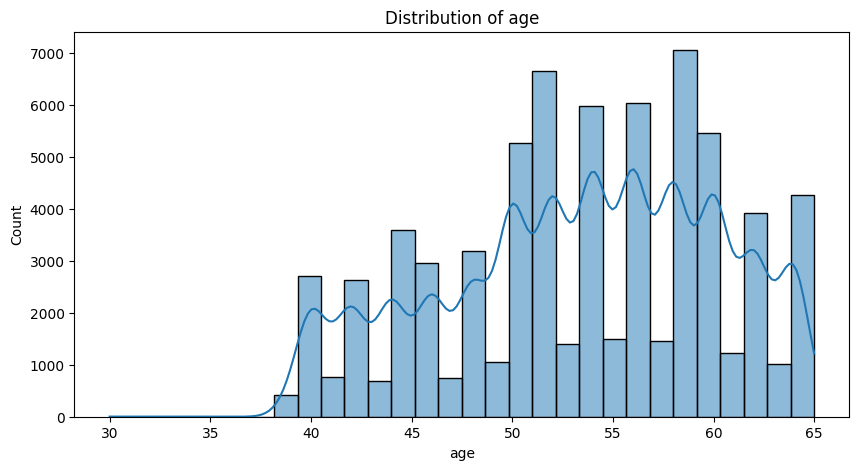

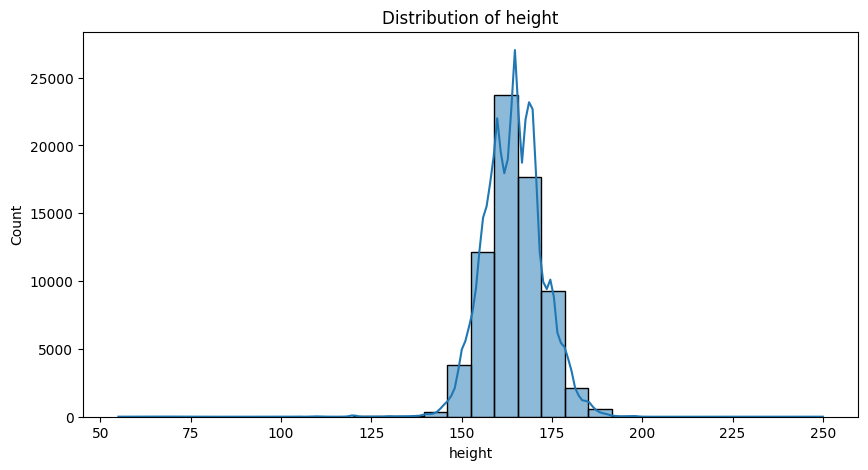

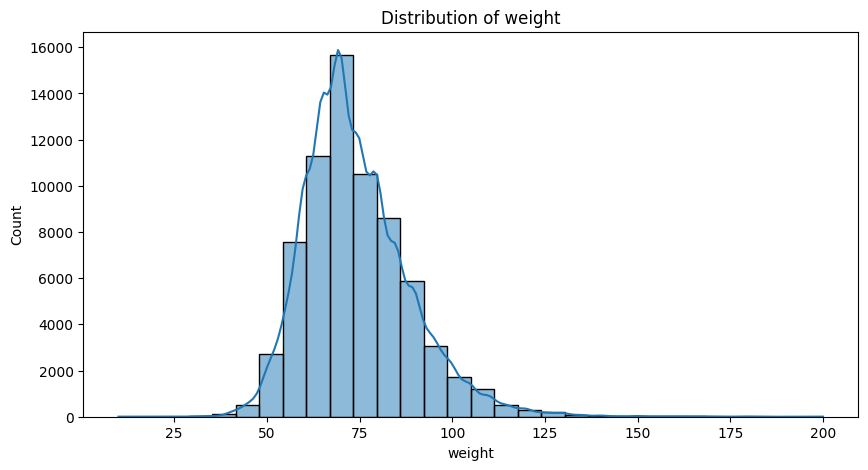

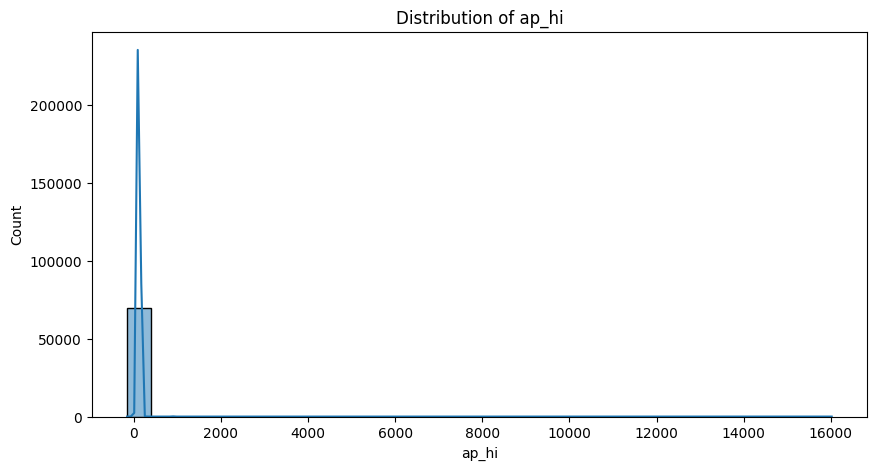

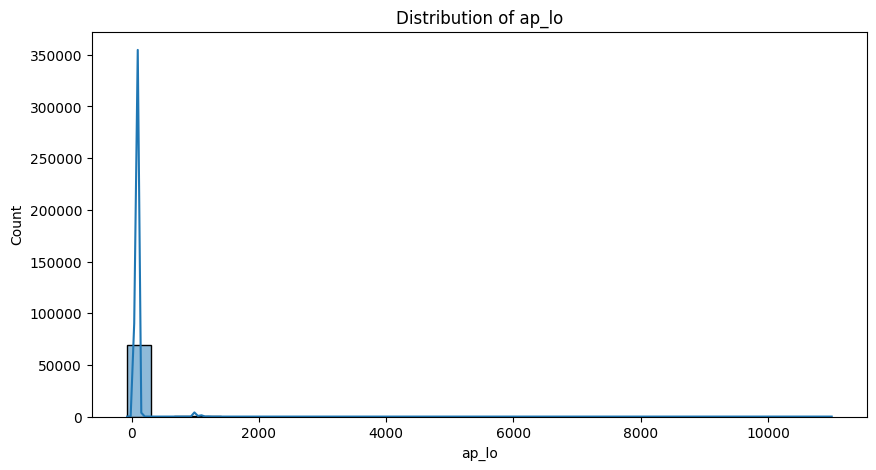

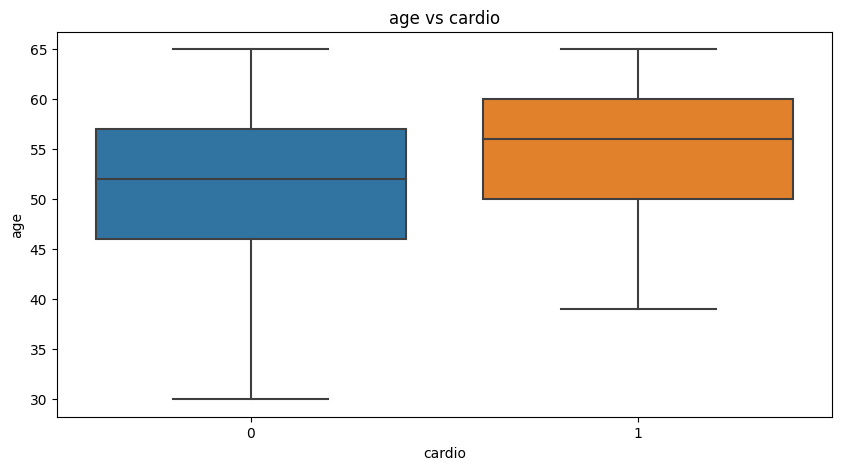

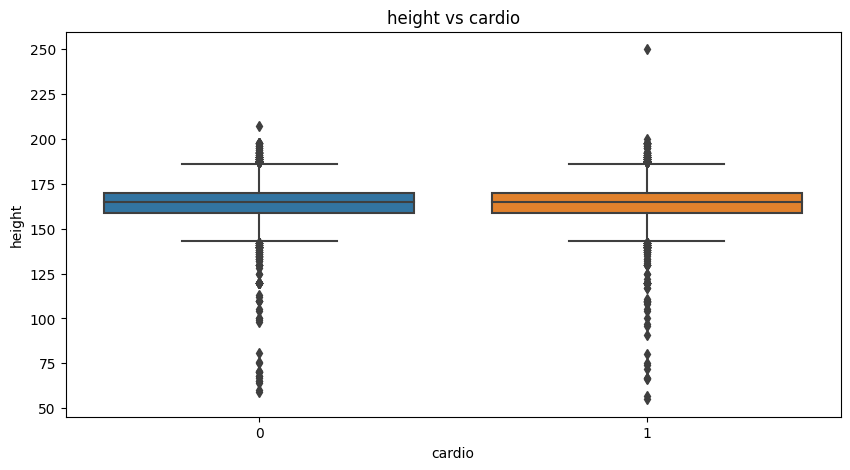

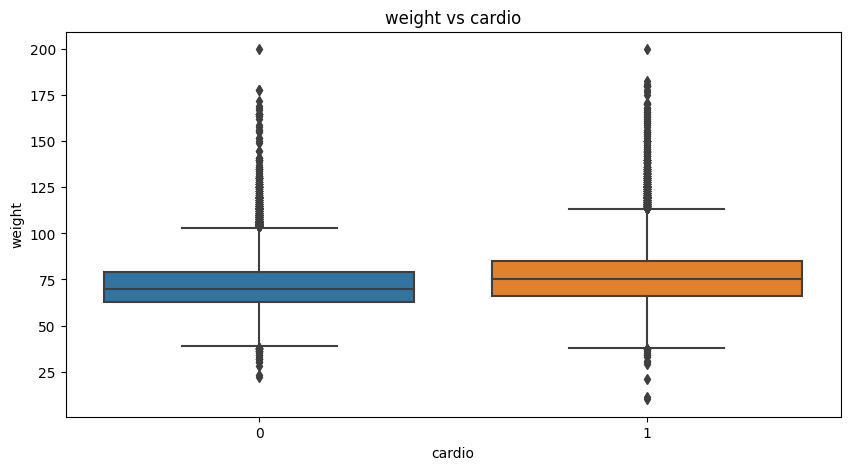

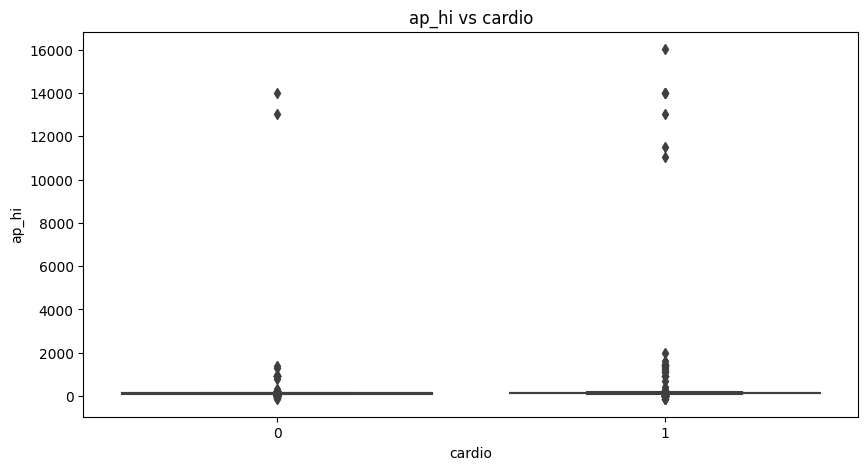

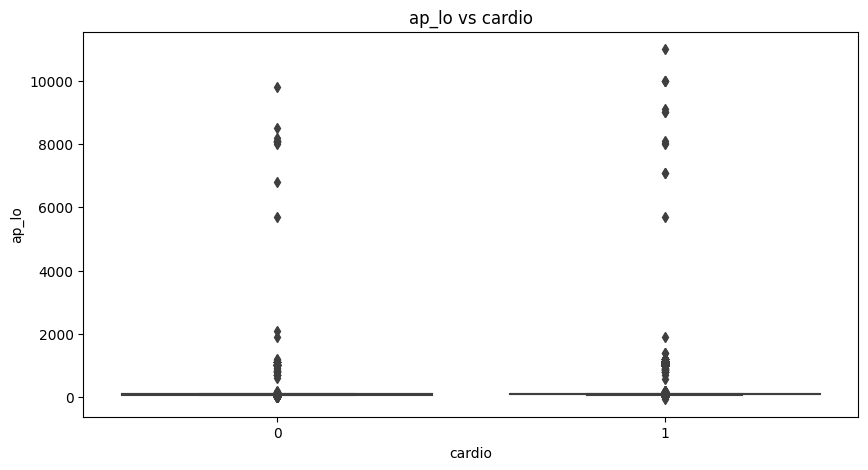

In [5]:
# Convert age from days around to years 
data['age'] = (data['age'] / 365) .round().astype('int')

# List of numerical columns
num_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Plot histograms for numerical columns
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


# Plot boxplots of numerical columns against the target variable
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='cardio', y=col, data=data)
    plt.title(f'{col} vs cardio')
    plt.show()

<Axes: xlabel='cardio', ylabel='Count'>

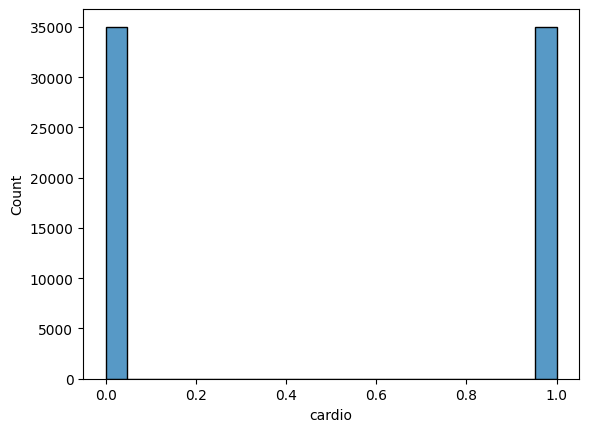

In [6]:
#distribution of cardio column
sns.histplot(data['cardio'])

## Orignial Data Analysis - numerical variables

Age: The distribution is slightly left-skewed. Most of the patients are in the age range of 40 to 65 years. The age of individuals with cardiovascular disease (cardio=1) is generally higher than those without the disease (cardio=0). 

Height: The distribution is roughly normal, with most heights ranging between 150 and 180 cm. There are some values at the lower end that could be considered outliers.  The median height is slightly lower for individuals with cardiovascular disease (cardio=1) compared to those without the disease (cardio=0). 

Weight: The distribution is slightly right-skewed, with most weights ranging between 50 and 100 kg.  
Individuals with cardiovascular disease (cardio=1) tend to have higher weight than those without the disease (cardio=0). 

ap_hi and ap_lo: These distributions are heavily affected by outliers, and it's hard to make out the true distributions.

Individuals with cardiovascular disease (cardio=1) tend to have higher systolic blood pressure (ap_hi) than those without the disease (cardio=0). 
Individuals with cardiovascular disease (cardio=1) tend to have higher diastolic blood pressure (ap_lo) than those without the disease (cardio=0).

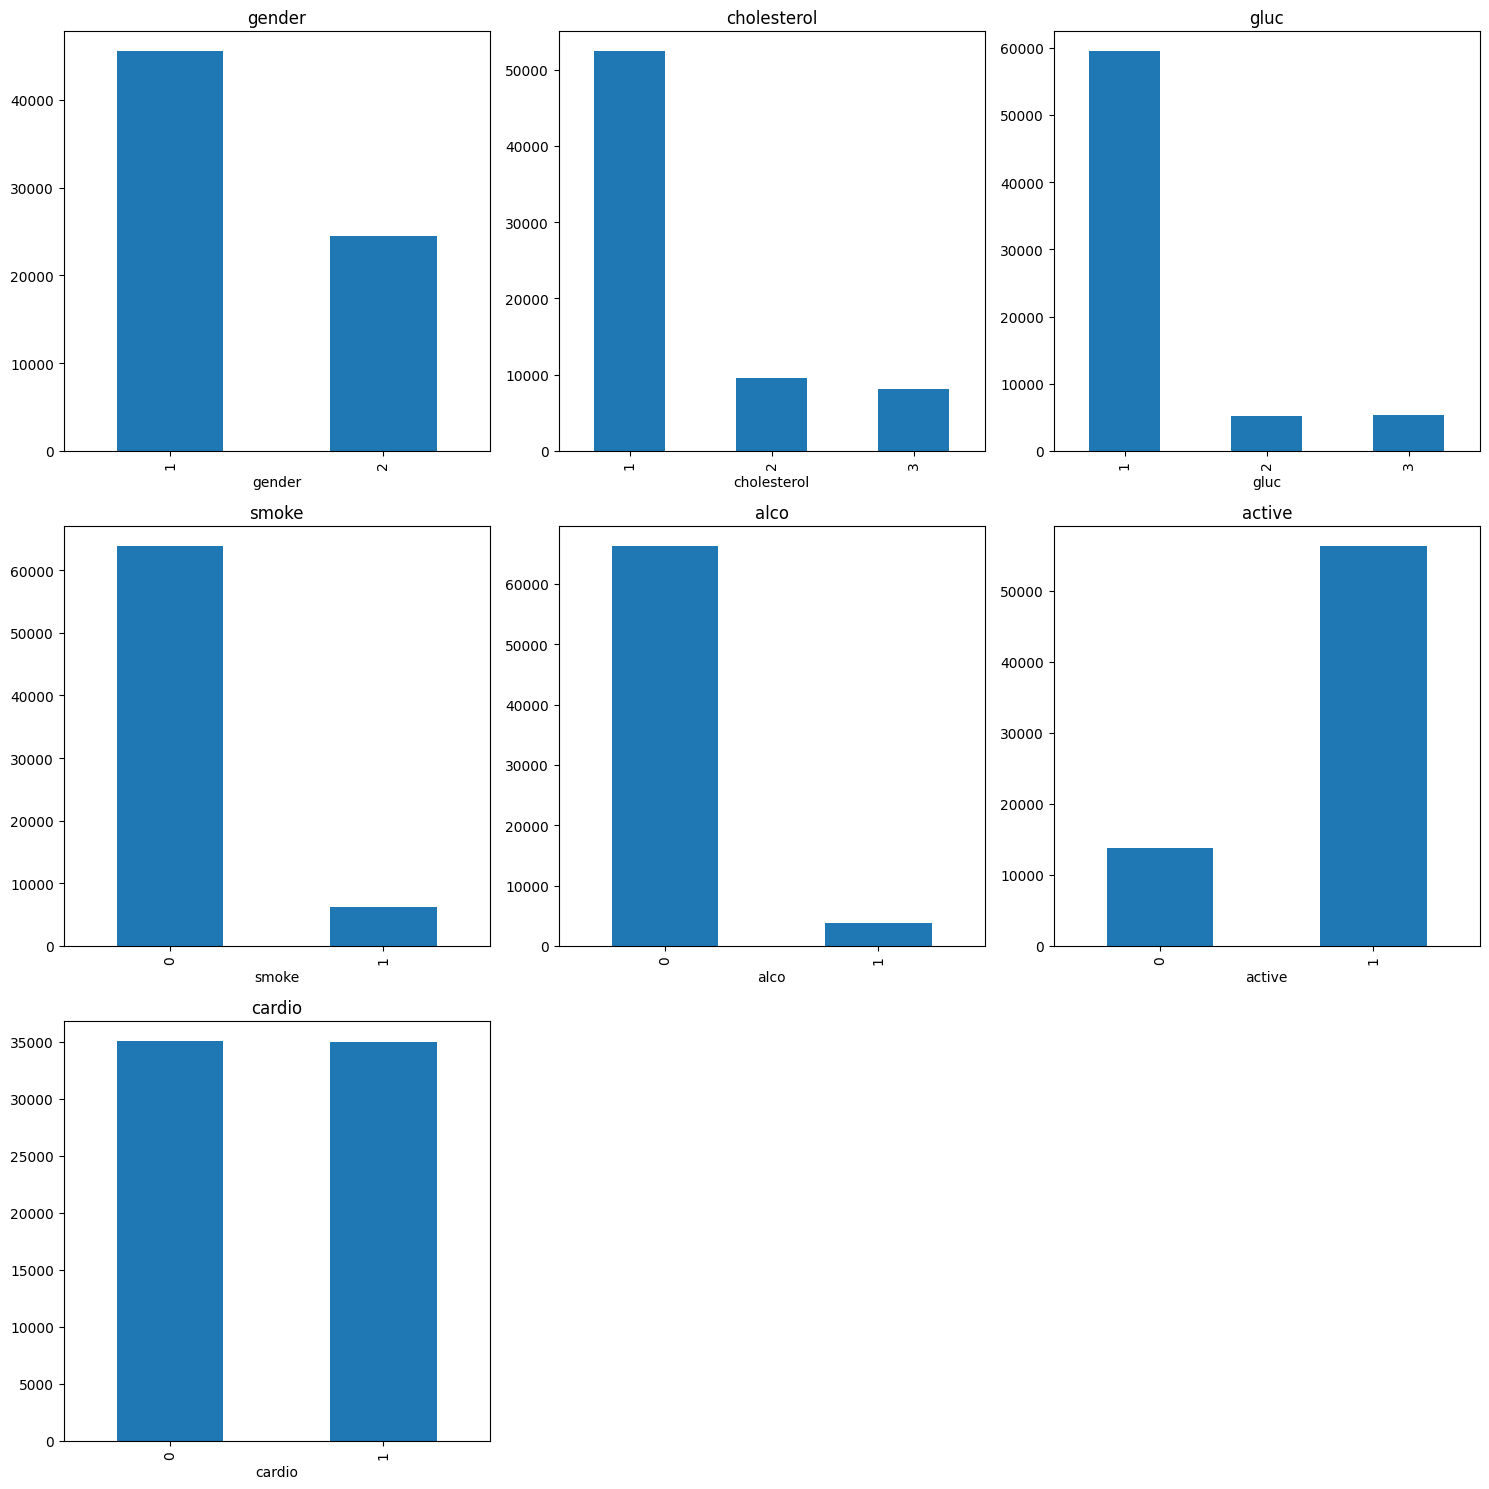

In [7]:
# Select categorical columns
categorical_columns = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Create bar plots for each categorical column
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for column, ax in zip(categorical_columns, axs.flatten()):
    data[column].value_counts().sort_index().plot(kind='bar', ax=ax, title=column)

# Remove unused subplots
for ax in axs.flatten()[len(categorical_columns):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

# Original data analysis - categorical variables

Gender: There are more individuals of gender 1 (female) than gender 2 (male).

Cholesterol: Most individuals have a normal cholesterol level (1), but a significant number have above normal (2) and well above normal (3) levels.

Glucose (gluc): Similar to cholesterol, most individuals have a normal glucose level (1), but a significant number have above normal (2) and well above normal (3) levels.

Smoke: The majority of individuals in the dataset are non-smokers.

Alcohol (alco): The majority of individuals in the dataset do not consume alcohol.

Physical Activity (active): Most individuals in the dataset are physically active.

Cardiovascular Disease (cardio): The dataset is fairly balanced in terms of individuals with and without cardiovascular disease.

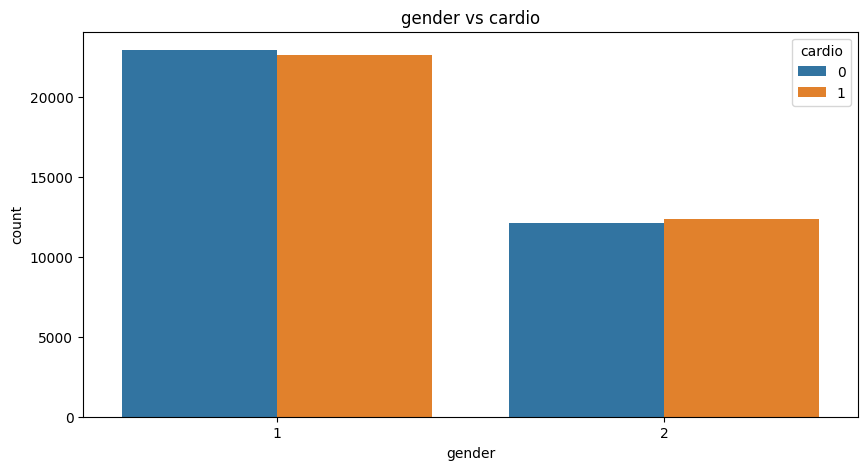

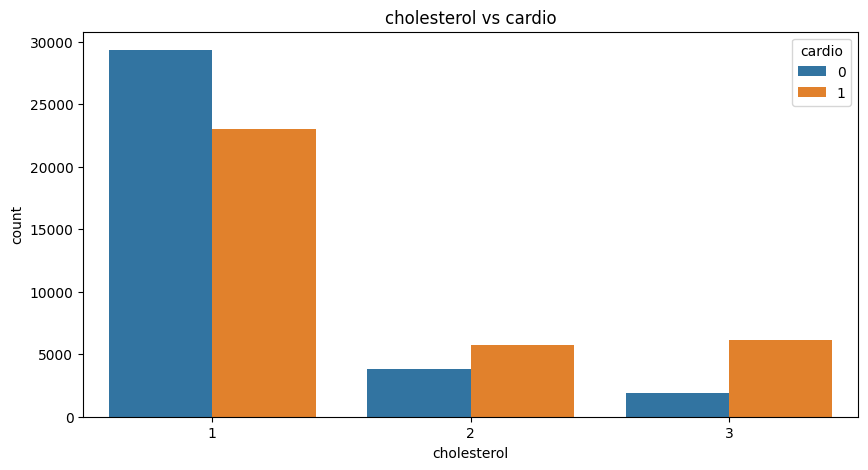

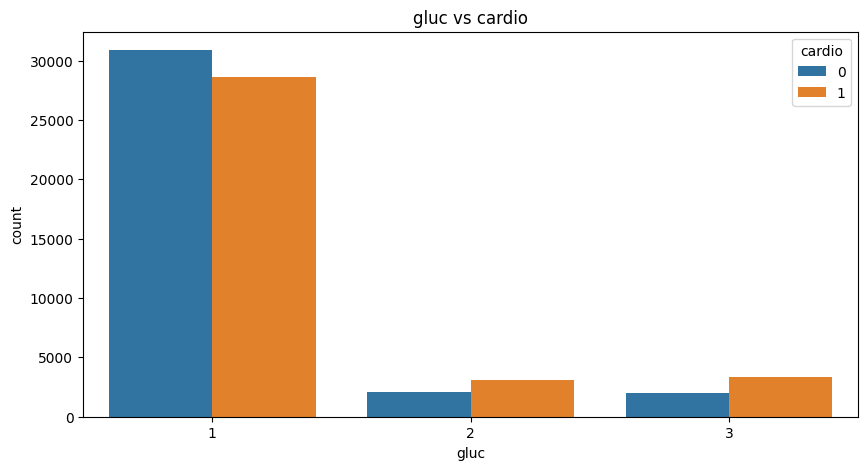

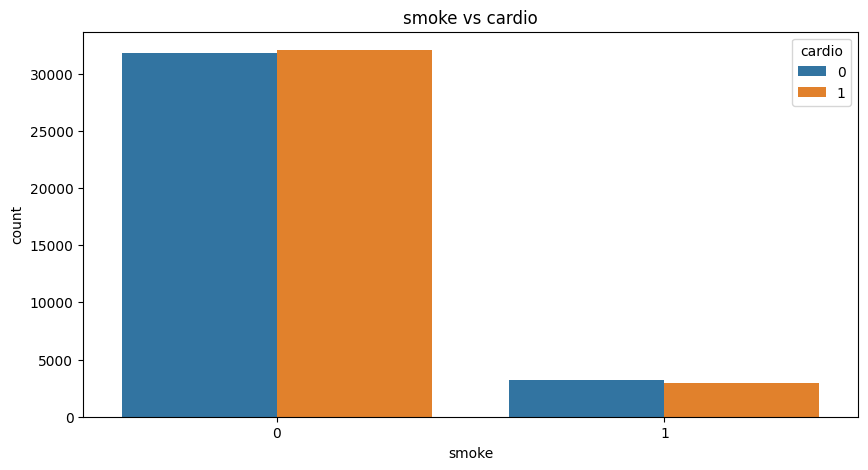

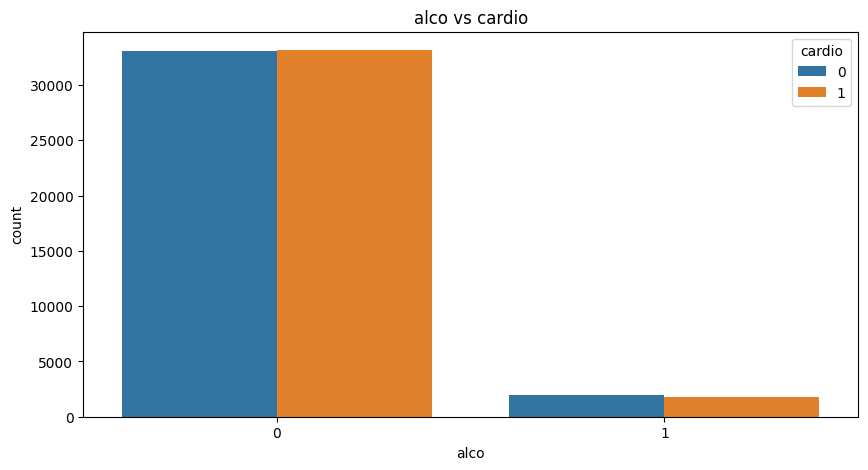

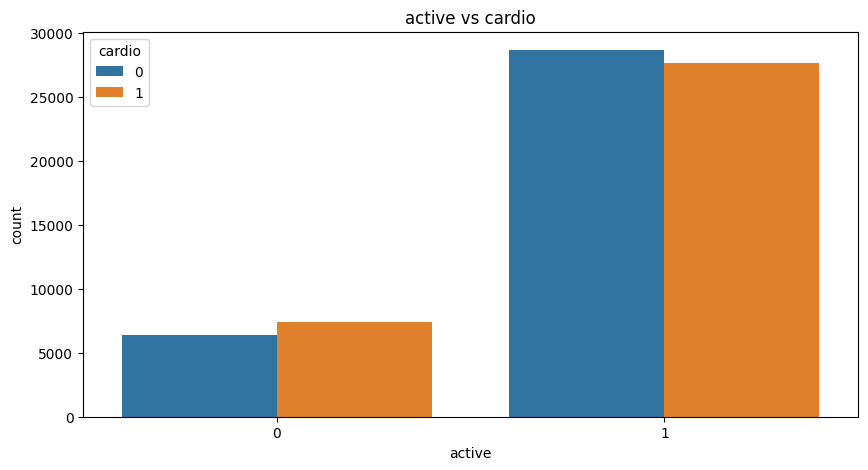

In [8]:
# List of categorical variables
cat_cols =['gender','cholesterol','gluc','smoke', 'alco','active']

# Plot countplots of categorical columns against the target variable
for col in cat_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, hue='cardio', data= data)
    plt.title(f'{col} vs cardio')
    plt.show()

# Original categorical data vs. cardio(target variable)

Gender: There doesn't appear to be a significant difference in the prevalence of cardiovascular disease between the two genders.

Cholesterol: Individuals with above normal (2) and well above normal (3) cholesterol levels seem to have a higher prevalence of cardiovascular disease than those with normal levels (1).

Glucose (gluc): Similar to cholesterol, individuals with above normal (2) and well above normal (3) glucose levels seem to have a higher prevalence of cardiovascular disease than those with normal levels (1).

Smoke: There doesn't seem to be a significant difference in the prevalence of cardiovascular disease between smokers and non-smokers.

Alcohol (alco): There doesn't seem to be a significant difference in the prevalence of cardiovascular disease between those who consume alcohol and those who do not.

Physical Activity (active): Individuals who are not physically active seem to have a slightly higher prevalence of cardiovascular disease than those who are active.

These observations suggest that cholesterol and glucose levels may be associated with the prevalence of cardiovascular disease, while the other factors (gender, smoking status, alcohol consumption, and physical activity level) do not appear to have a strong association with the disease in this dataset.

In [9]:
# Since weight is a important factor for cardio, we create BMI to measure
# Create a BMI column
data['bmi'] = data['weight'] / (data['height'] / 100) ** 2

In [10]:
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438
69996,99995,62,1,158,126.0,140,90,2,2,0,0,1,1,50.472681
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


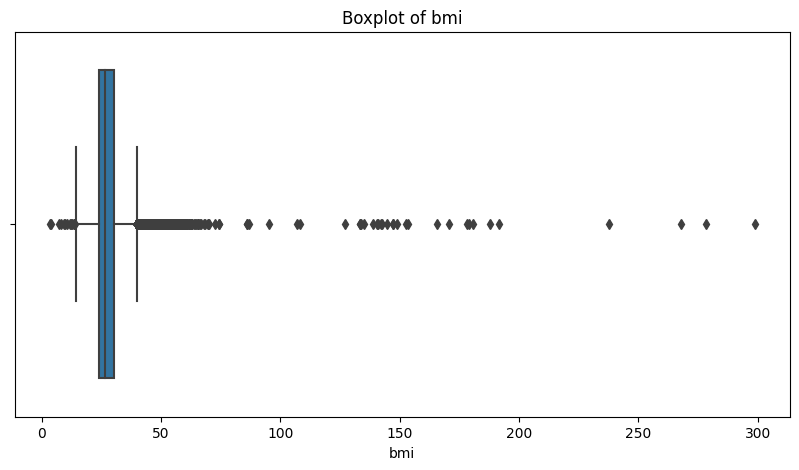

In [11]:
# Plot a boxplot for 'bmi'
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['bmi'])
plt.title('Boxplot of bmi')
plt.show()

## Data Cleaning - outliers

Age  range: 40 - 65
From the distribution of age, we set the age range between 40 and 65 years, excluding four outliers who were younger than 30 years.

Height range : 100 cm - 220 cm 
Height has a minimum of 55 cm and a maximum of 250 cm. Heights below 100 cm or above 220 cm could be considered as outliers since these are quite uncommon values for adult human heights.

Wieght : 40kg  - 140kg 
weight has a minimum of 10 kg and a maximum of 200 kg. Weights below 40 kg or above 140 kg could be considered as outliers since these are quite uncommon values for adult human weights.

ap_hi and ap_lo : ap_hi 80 - 190 ; ap_lo 50 - 120 
contain some unrealistic values that we need to handle. Let's address these outliers next. We will consider systolic values (ap_hi) below 70 and above 190, and diastolic values (ap_lo) below 40 and above 120 as outliers and remove them from the dataset. These thresholds are set based on medical knowledge about typical blood pressure values.
Reason to remove: they are likely to be errors and don't represent typical human blood pressure values.

BMI: 15 - 45. A BMI below 15 or above 45 is quite uncommon. A BMI below 15 is considered very severely underweight, while a BMI above 45 is considered very severely obese.

In [12]:
# Compute the IQR for 'age'
Q1_age = data['age'].quantile(0.25)
Q3_age = data['age'].quantile(0.75)
IQR_age = Q3_age - Q1_age

# Define the boundaries for outliers
lower_bound = Q1_age - 1.5 * IQR_age
upper_bound = Q3_age + 1.5 * IQR_age

# Identify the outliers
outliers_age = data[(data['age'] < lower_bound) | (data['age'] > upper_bound)]

# Display the outliers
outliers_age


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
6219,8850,30,1,175,59.0,120,80,1,1,0,0,1,0,19.265306
22343,31922,30,2,175,92.0,100,60,1,1,0,0,1,0,30.040816
30666,43842,30,1,159,59.0,120,80,1,1,0,0,1,0,23.337684
55905,79749,30,1,160,59.0,110,70,1,1,0,0,1,0,23.046875


In [13]:
# Copy the original dataset
data_copy = data.copy()

# Define the thresholds
height_thresholds = [100, 220]
weight_thresholds = [40, 140]
ap_hi_thresholds = [70, 190]
ap_lo_thresholds = [40, 120]
bmi_thresholds = [15, 45]

# Calculate the number of outliers for each variable
height_outliers = data_copy[(data_copy['height'] < height_thresholds[0]) | (data_copy['height'] > height_thresholds[1])].shape[0]
weight_outliers = data_copy[(data_copy['weight'] < weight_thresholds[0]) | (data_copy['weight'] > weight_thresholds[1])].shape[0]
ap_hi_outliers = data_copy[(data_copy['ap_hi'] < ap_hi_thresholds[0]) | (data_copy['ap_hi'] > ap_hi_thresholds[1])].shape[0]
ap_lo_outliers = data_copy[(data_copy['ap_lo'] < ap_lo_thresholds[0]) | (data_copy['ap_lo'] > ap_lo_thresholds[1])].shape[0]
bmi_outliers = data_copy[(data_copy['bmi'] < bmi_thresholds[0]) | (data_copy['bmi'] > bmi_thresholds[1])].shape[0]

# Print the number of outliers for each variable
height_outliers, weight_outliers, ap_hi_outliers, ap_lo_outliers, bmi_outliers


(30, 150, 409, 1115, 632)

In [14]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,27.556513
std,28851.302323,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.091511
min,0.000000,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784
25%,25006.750000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,50001.500000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.374068
75%,74889.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.222222
max,99999.000000,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667


In [15]:
# Remove age outliers
data = data[(data['age'] >= lower_bound) & (data['age'] <= upper_bound)]

# Remove height outliers
data = data[(data['height'] >= 100) & (data['height'] <= 220)]

# Remove weight outliers
data = data[(data['weight'] >= 40) & (data['weight'] <= 140)]

# Remove blood pressure outliers
data = data[(data['ap_hi'] >= 80) & (data['ap_hi'] <= 190)]
data = data[(data['ap_lo'] >= 50) & (data['ap_lo'] <= 120)]

# Remove BMI outliers
data = data[(data['bmi'] >= 15) & (data['bmi'] <= 45)]

# Show the all rows of  cleaned data
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,0,1,1,29.384757
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


The data is cleaned now.

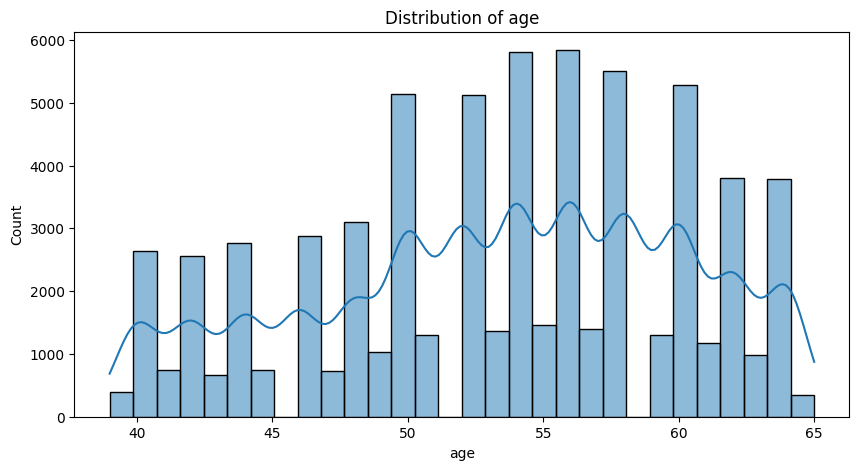

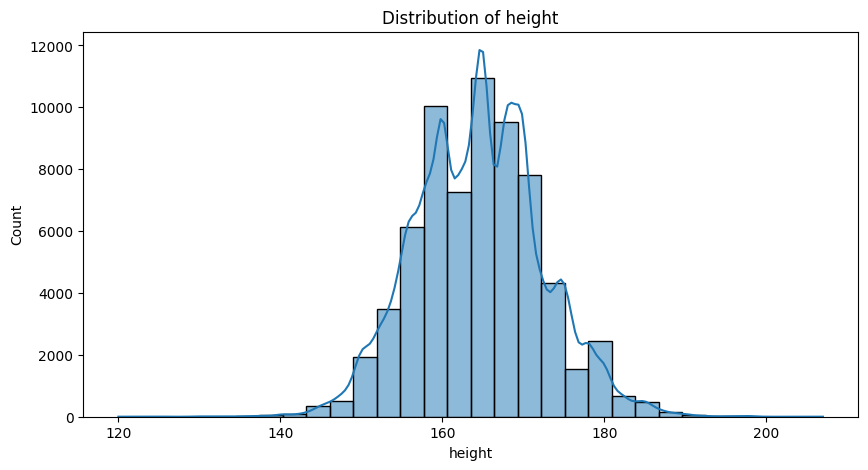

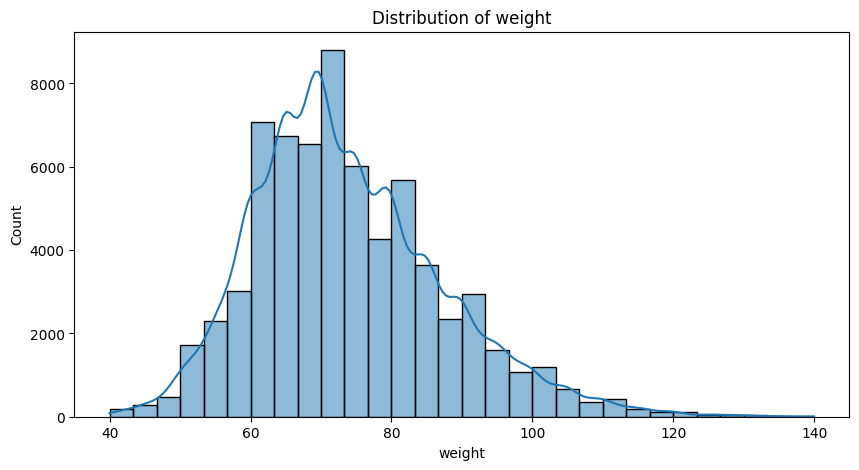

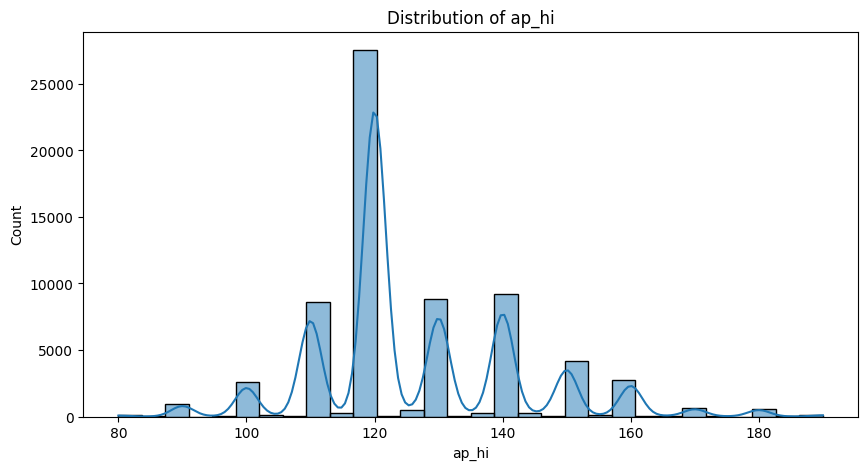

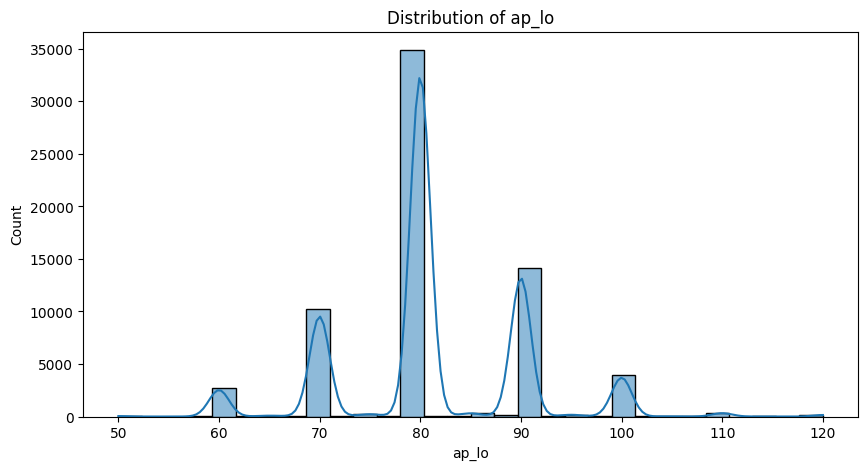

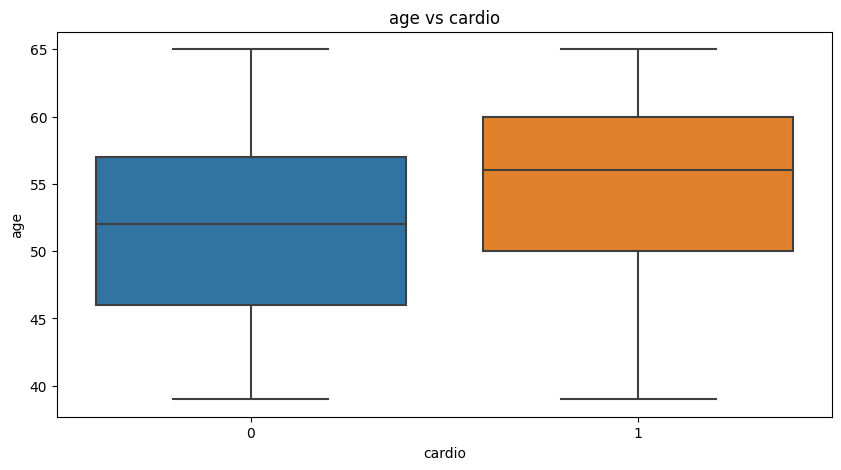

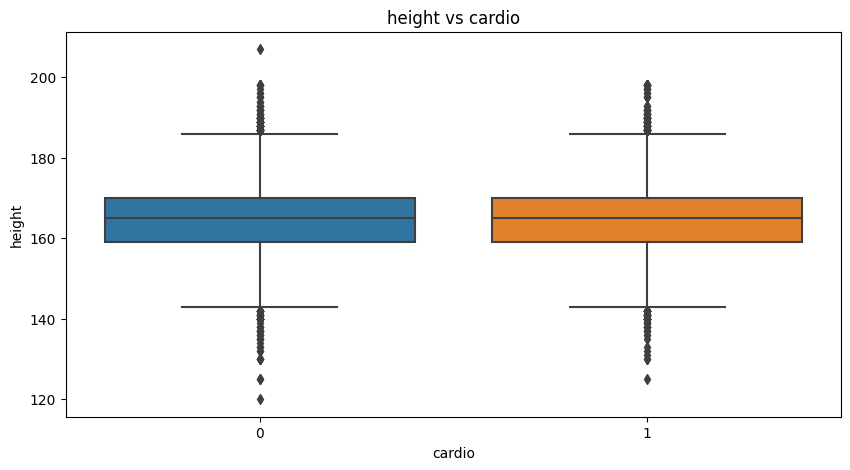

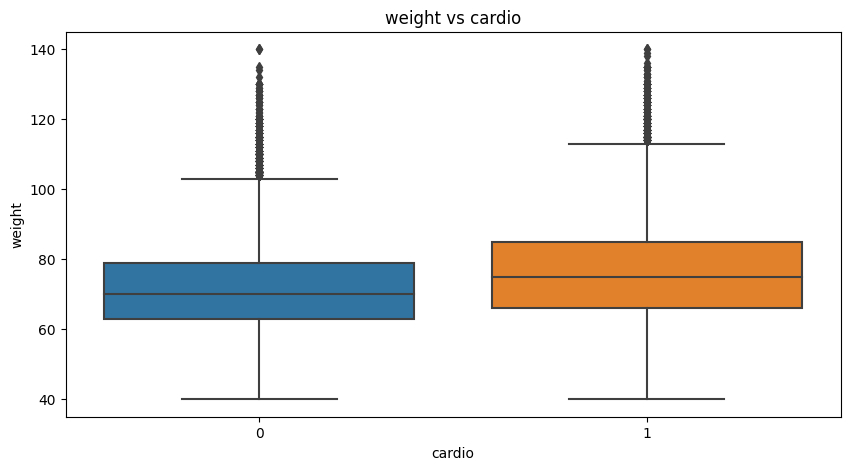

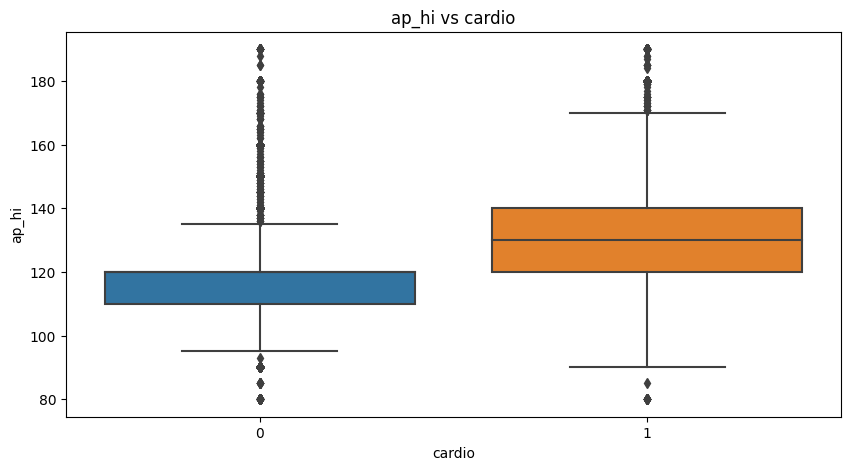

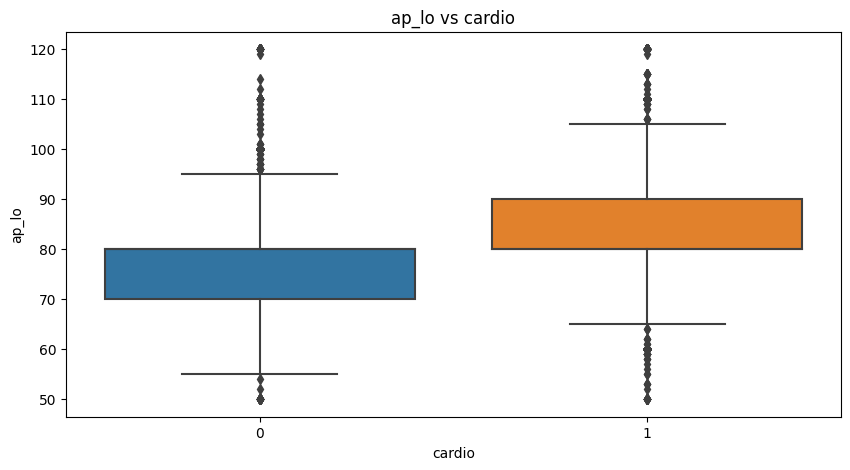

In [16]:
# Plot  new histograms for numerical columns
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


# Plot new boxplots of numerical columns against the target variable
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='cardio', y=col, data=data)
    plt.title(f'{col} vs cardio')
    plt.show()

<Axes: xlabel='cardio', ylabel='Count'>

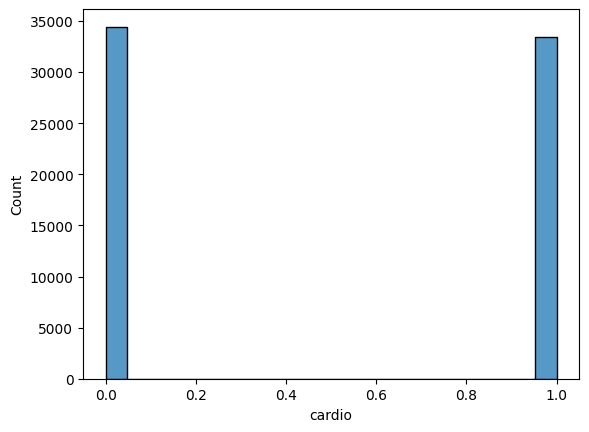

In [17]:
#distribution of cardio column
sns.histplot(data['cardio'])

In [18]:
#number of people who have cardiovascular 
(data['cardio']==1).sum()


33436

In [19]:
#Number of people who don't have it
(data['cardio']==0).sum()

34442

After the cleaning the dataset still balance

In [20]:
data.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
count,67878.000000,67878.000000,67878.000000,67878.000000,67878.000000,67878.000000,67878.000000,67878.000000,67878.000000,67878.000000,67878.000000,67878.000000,67878.000000,67878.000000
mean,49977.712499,53.319455,1.350113,164.480318,73.739196,126.391438,81.218362,1.361826,1.223268,0.088129,0.053272,0.803500,0.492590,27.282870
std,28851.770832,6.767716,0.477009,7.816056,13.490588,16.225181,9.252232,0.676843,0.569122,0.283484,0.224577,0.397354,0.499949,4.839981
min,0.000000,39.000000,1.000000,120.000000,40.000000,80.000000,50.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,15.035584
25%,24995.250000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,50028.500000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.291724
75%,74876.750000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.083829
max,99999.000000,65.000000,2.000000,207.000000,140.000000,190.000000,120.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,44.997166


In the data cleaning process, we removed certain outliers and observations that were below the first quartile for the 'age' variable. The impact of this cleaning process on the dataset can be observed in the changes to the mean values of several variables.

- Age: The average age saw a minor decrease from 53.3387 years to 53.3000 years. This small change suggests that the removed outliers had ages close to the overall average.
  
- Height: The average height had a slight increase from 164.3592 cm to 164.5697 cm. This change is not significant and suggests that the data cleaning did not heavily impact this variable.
  
- Weight: The average weight decreased from 74.2057 kg to 73.1345 kg. This indicates that some of the removed outliers or observations had weights above the average.
  
- Ap_hi: The average systolic blood pressure ('ap_hi') decreased from 128.8173 to 126.1942. This suggests that the removed observations had higher systolic blood pressure compared to the average.
  
- Ap_lo: The average diastolic blood pressure ('ap_lo') showed a significant decrease from 96.6304 to 81.1229. This large decrease indicates that the removed outliers had considerably higher diastolic blood pressure than the average.
  
- BMI: The average Body Mass Index (BMI) decreased from 27.5565 to 27.0160. This change suggests that some of the removed outliers or observations were above the average BMI.

These changes in the means of the variables provide valuable insights into the characteristics of the outliers and observations that were removed during the data cleaning process.

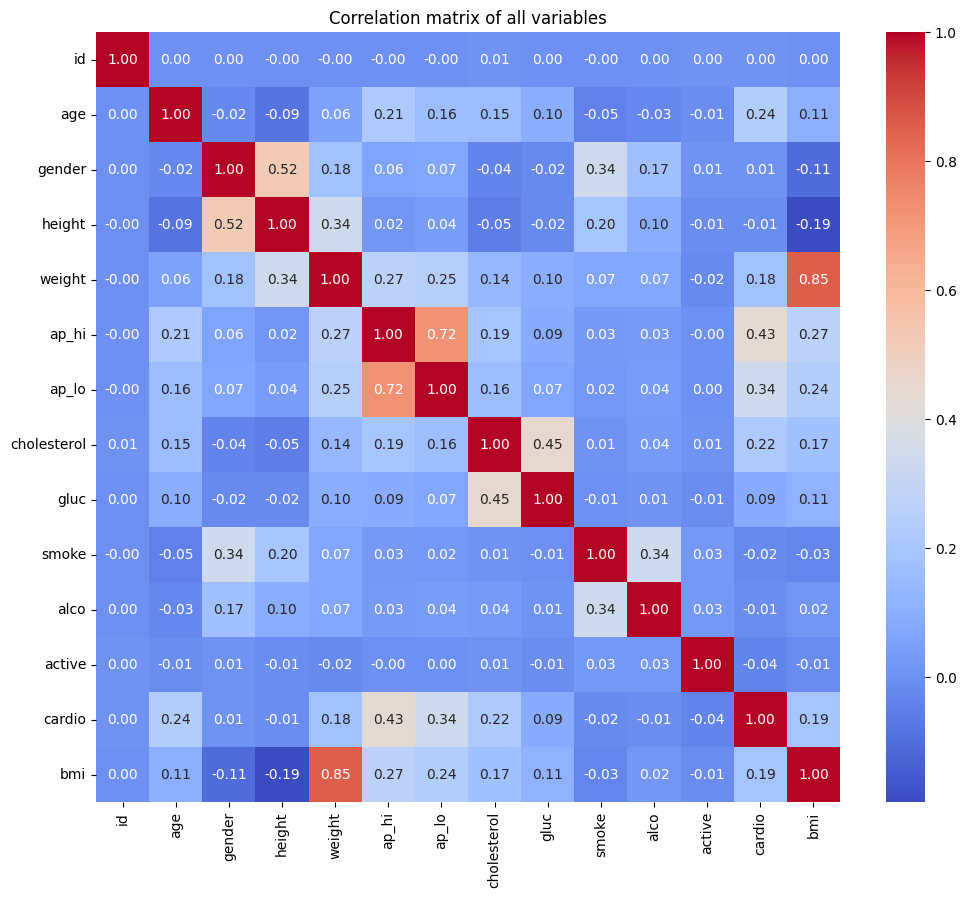

In [21]:
# Calculate correlation matrix
corr = data.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation matrix of all variables')
plt.show()

Now, 

age(0.24), weight(0.17), ap_hi(0.43), ap_lo(0.34),cholesterol(0.22) and bmi (0.19) show a moderate positive correlation with the presence of cardiovascular disease (cardio).
age and cardio: There is a positive correlation coefficient (0.24), indicating that the risk of cardiovascular disease tends to increase with age.
weight and ap_hi/ap_lo: There is a positive correlation between weight and both systolic (0.26) and diastolic (0.24) blood pressure. This suggests that higher weight may be associated with higher blood pressure.
cholesterol and cardio: There is a moderate positive correlation (0.22), suggesting that high cholesterol levels could be a risk factor for cardiovascular disease.
ap_hi and cardio: There is a moderate positive correlation (0.43), indicating that higher systolic blood pressure is associated with a higher risk of cardiovascular disease.
ap_lo and cardio: There is also a moderate positive correlation (0.34), indicating that higher diastolic blood pressure is associated with a higher risk of cardiovascular disease.
BMI and cardio: There is a positive coefficient(0.19),indicating that higher BMI is associated with a higher risk of cardiovascular disease.
Also this corresponds to our hypothesis that age, blood pressure and cholesterol level are indeed the three most influential factors

active lifestyle shows a slight negative correlation with cardio, indicating that active individuals have a slightly lower chance of having cardiovascular disease.


gender doesn't seem to have a significant correlation with cardio.

ap_hi and ap_lo are reasonably correlated with each other, which is expected as they both pertain to blood pressure.

cholesterol and gluc(0.09) are also somewhat correlated. This is not surprising, as these two can be related in terms of diet and lifestyle.

# Feature Engineering

After the above, we are going to be building predictive model
1. logistic regression
2. Random forest 
3. knn
4. svc

In [22]:
#build a generic model 
#define all the columns
data.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi'],
      dtype='object')

In [23]:
data


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,0,1,1,29.384757
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251


Feature engineering 

determine if someone has high blood pressure or not- normal blood pressure is 120/80 or less - 120 systolic and 80 diastolic

Determine if the patient has high Glucose or not

Determine if the patient has high cholesterol or not

Determine if the person is overweight if BMI is 25.0 and over

conversion of glucose and cholestrol to dummy variable


In [24]:
#map Glucose and cholesterol to determine high glucose and high cholesterol
map_dic = {1:0,2:1,3:1}
data['high_glu'] = data['gluc'].map(map_dic)
data['high_chol'] = data['cholesterol'].map(map_dic)

In [25]:
#BMI to weight measure 
def over_weight(x):
    if x >= 25:
        return 1
    elif x < 25:
        return 0

#apply function to data 
data['over_weight'] = data['bmi'].apply(over_weight)
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,high_glu,high_chol,over_weight
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,0,0,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,0,1,1
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,0,1,0
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,0,0,1
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,0,0,1
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,0,0,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,0,1,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,1,0,1


In [26]:
#convert systolic (ap_hi) and diastolic (ap_lo) to blood pressure measure (high and low blood pressure)
def high_bp(app_hi, app_lo):
    if app_hi > 120 and app_lo > 80:
        return 1
    else:
        return 0

def low_bp(app_hi, app_lo):
    if app_hi <= 90 and app_lo <= 60:
        return 1
    else:
        return 0

data['high_bp'] = data.apply(lambda x: high_bp(x['ap_hi'], x['ap_lo']),axis=1)
data['low_bp'] = data.apply(lambda x: low_bp(x['ap_hi'], x['ap_lo']), axis=1)

data


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,high_glu,high_chol,over_weight,high_bp,low_bp
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,0,0,0,0,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,0,1,1,1,0
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,0,1,0,0,0
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,0,0,1,1,0
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,0,1,1,29.384757,0,0,1,0,0
69995,99993,53,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,0,0,1,0,0
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1,31.353579,0,1,1,1,0
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,1,0,1,0,0


Numerical variables: age, height, weight, ap_hi, ap_lo,BMI

Categorical variables: gender, cholesterol, gluc, smoke, alco, active, cardio, high_glu, high_chol, over_weight, high_bp, low_bp

In [27]:
#convert gluc to dummies
dummies_gluc = pd.get_dummies(data.gluc, dtype=int)
dummies_gluc.rename(columns = {1:'gluc_norm', 2:'gluc_ab', 3:'gluc_wab'}, inplace = True)
data = pd.concat([data,dummies_gluc],axis=1)

In [28]:
#convert cholesterol to dummies
dummies_chol = pd.get_dummies(data.cholesterol, dtype=int)
dummies_chol.rename(columns = {1:'chol_norm', 2:'chol_ab', 3:'chol_wab'}, inplace = True)
data = pd.concat([data,dummies_chol],axis=1)

In [29]:
#print the data
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,high_chol,over_weight,high_bp,low_bp,gluc_norm,gluc_ab,gluc_wab,chol_norm,chol_ab,chol_wab
0,0,50,2,168,62.0,110,80,1,1,0,...,0,0,0,0,1,0,0,1,0,0
1,1,55,1,156,85.0,140,90,3,1,0,...,1,1,1,0,1,0,0,0,0,1
2,2,52,1,165,64.0,130,70,3,1,0,...,1,0,0,0,1,0,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,...,0,1,1,0,1,0,0,1,0,0
4,4,48,1,156,56.0,100,60,1,1,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,...,0,1,0,0,1,0,0,1,0,0
69995,99993,53,2,168,76.0,120,80,1,1,1,...,0,1,0,0,1,0,0,1,0,0
69997,99996,52,2,183,105.0,180,90,3,1,0,...,1,1,1,0,1,0,0,0,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,...,0,1,0,0,0,1,0,1,0,0


In [30]:
data.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi',
       'high_glu', 'high_chol', 'over_weight', 'high_bp', 'low_bp',
       'gluc_norm', 'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab'],
      dtype='object')

In [31]:
#change the name overweight to high_bmi
data = data.rename(columns={'over_weight':'high_bmi'})

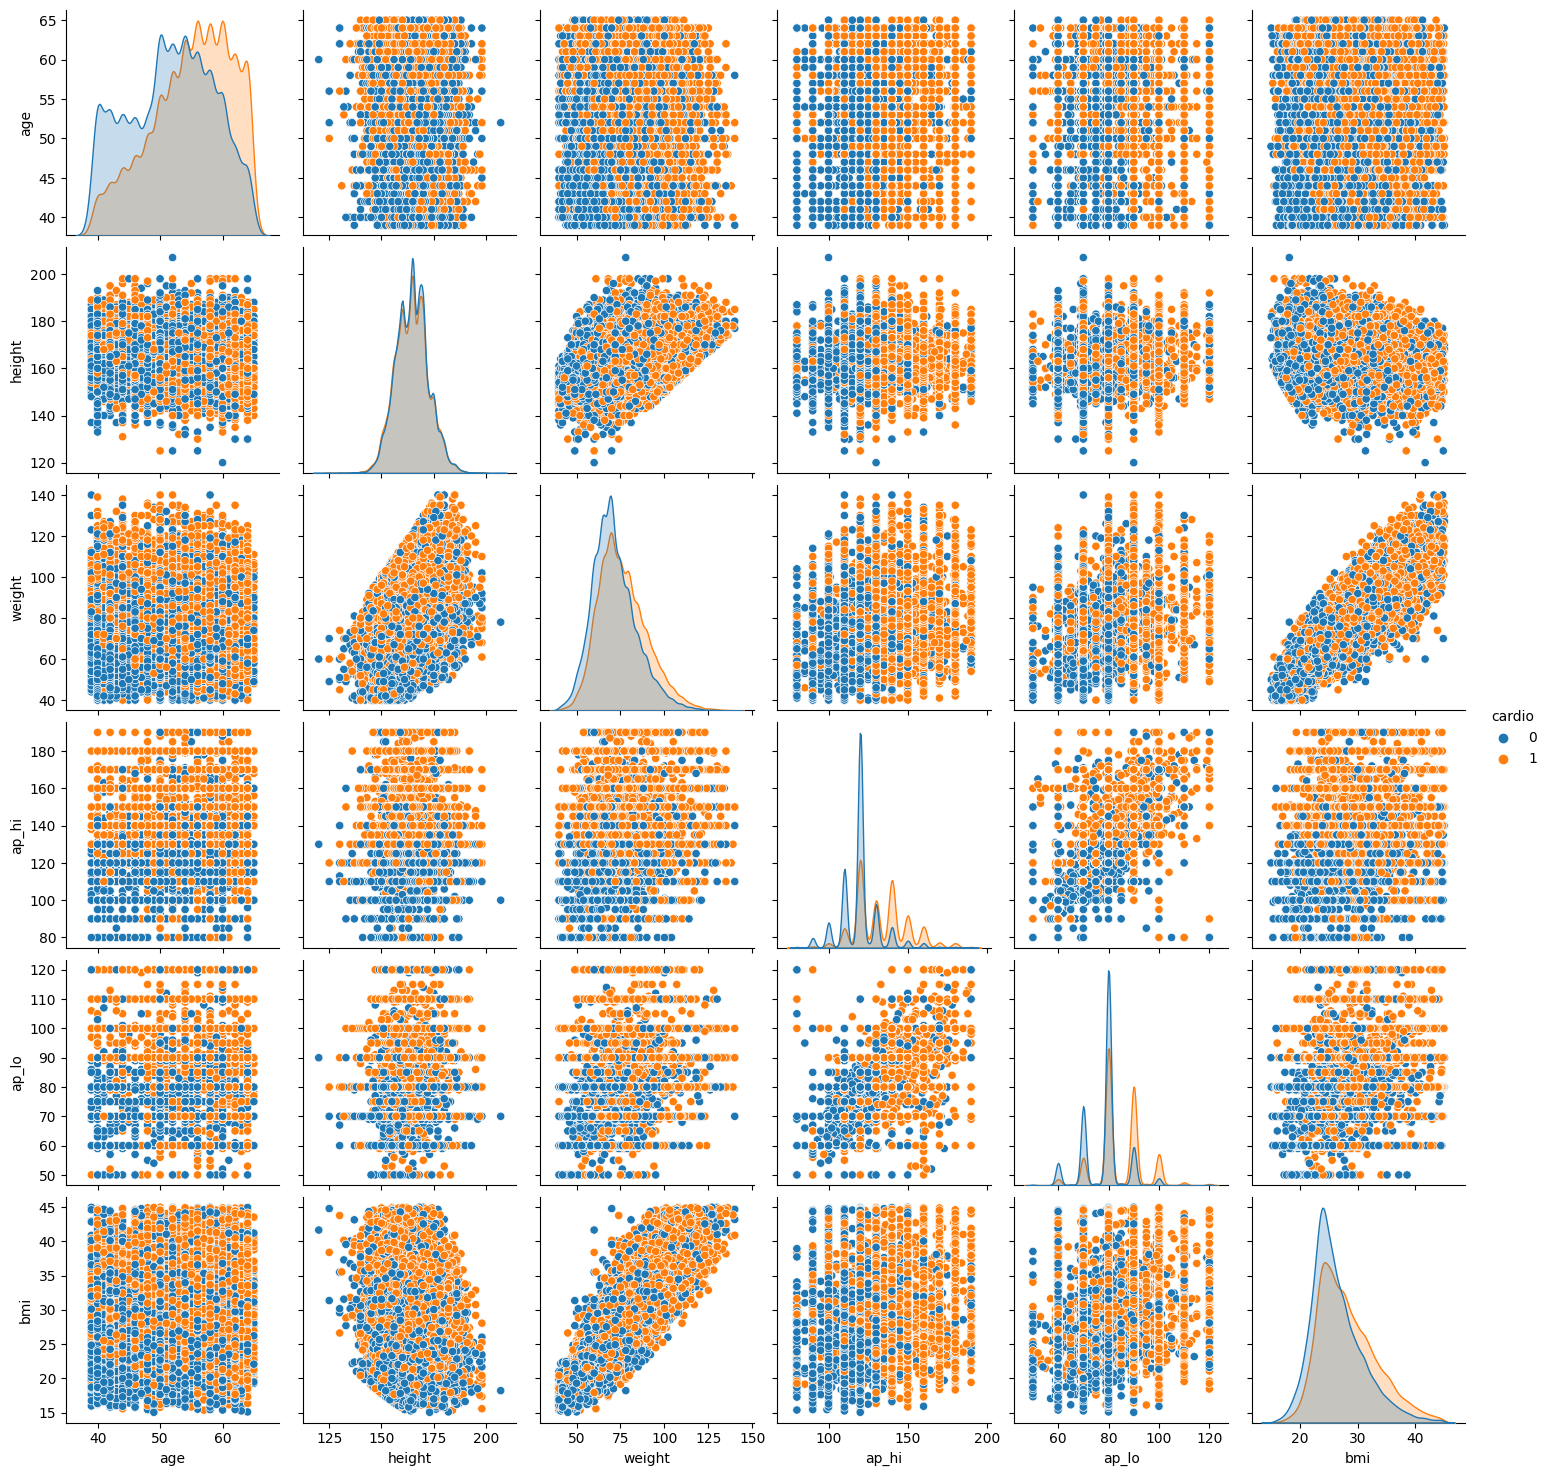

In [32]:
#plot a pair plot graph 
num_col = ['age','height','weight','ap_hi','ap_lo','bmi','cardio']
sns.pairplot(data[num_col],hue='cardio')

From the above it is visible that age,ap_hi,ap_lo, bmi and weight listed in the order of strenght play a major role in determing if a person has cardio-vascula disease or not . height however is not a strong determinant

Categorical variables: gender, cholesterol, gluc, smoke, alco, active, cardio, high_glu, high_chol, over_weight, high_bp, low_bp

In [33]:
#define function to percentage 
def cat_var(x,y,count_var,df):
    variable = df.groupby([x,y])[[count_var]].count().unstack()
    variable['total'] = variable[count_var][0] + variable[count_var][1]
    variable['N_cardio'] = variable[count_var][0]/variable['total']
    variable['Y_cardio'] = variable[count_var][1]/variable['total']
    return variable


In [34]:
cardio_gen = cat_var('gender','cardio','age',data)
cardio_gen

#gender is a relative fair independent variable but not too strong because 48% of people with cardio are men and 49 are women
# it is a balanced view and not a strong determinant of cardio

age         total  N_cardio  Y_cardio
cardio      0      1                           
gender                                         
1       22511  21602  44113  0.510303  0.489697
2       11931  11834  23765  0.502041  0.497959

In [35]:
cardio_smoke = cat_var('smoke','cardio','age',data)
cardio_smoke
#smoking could be considered as a determinat but not really a strong determinant 

age         total  N_cardio  Y_cardio
cardio      0      1                           
smoke                                          
0       31248  30648  61896  0.504847  0.495153
1        3194   2788   5982  0.533935  0.466065

In [36]:
cardio_chol = cat_var('cholesterol','cardio','age',data)
cardio_chol
#from the below we can view that cholesterol is a good determinant of if a patient has
#cardio vascular disease or not. The more severe the cholesterol level, the more cases 
# of cardio vascular disease. 

age         total  N_cardio  Y_cardio
cardio           0      1                           
cholesterol                                         
1            28896  22133  51029  0.566266  0.433734
2             3703   5435   9138  0.405231  0.594769
3             1843   5868   7711  0.239009  0.760991

In [37]:
cardio_glu = cat_var('gluc','cardio', 'age',data)
cardio_glu
#from the below we can view that glucose is a good determinant of if a patient has
#cardio vascular disease or not. The more severe the glucose level, the more cases 
# of cardio vascular disease.

age         total  N_cardio  Y_cardio
cardio      0      1                           
gluc                                           
1       30424  27406  57830  0.526094  0.473906
2        2055   2886   4941  0.415908  0.584092
3        1963   3144   5107  0.384374  0.615626

In [38]:
cardio_hbp = cat_var('high_bp','cardio', 'age',data)
cardio_hbp
#from the below we can view that high blood pressure is a good determinant of if a patient has
#cardio vascular disease or not. more patients with high blood pressure have cardio vascular 
#disease

age         total  N_cardio  Y_cardio
cardio       0      1                           
high_bp                                         
0        30757  19152  49909  0.616262  0.383738
1         3685  14284  17969  0.205075  0.794925

In [39]:
cardio_lbp = cat_var('low_bp','cardio', 'age',data)
cardio_lbp
#from the below low blood pressure is a good indicator of cardio vascular disease 
#most individuals with low blood pressure did not have cardio vascular disease. 

age         total  N_cardio  Y_cardio
cardio      0      1                           
low_bp                                         
0       33730  33305  67035  0.503170  0.496830
1         712    131    843  0.844603  0.155397

In [40]:
cardio_active = cat_var('active','cardio', 'age',data)
cardio_active
#active is also a good determinant of cardio vascular disease as most people who were active 
#had less individuals with cardio vascular disease

age         total  N_cardio  Y_cardio
cardio      0      1                           
active                                         
0        6262   7076  13338  0.469486  0.530514
1       28180  26360  54540  0.516685  0.483315

In [41]:
cardio_alc = cat_var('alco','cardio', 'age',data)
cardio_alc
#alcohol is not a strong determinant of cardio vascular disease 
#as individuals who drink more alcohol dont seem to have more cardio vascular disease than those who do

age         total  N_cardio  Y_cardio
cardio      0      1                           
alco                                           
0       32542  31720  64262  0.506396  0.493604
1        1900   1716   3616  0.525442  0.474558

In [42]:
cardio_high_bmi = cat_var('high_bmi','cardio', 'age',data)
cardio_high_bmi
#This seems to be a fair determinant but really strong 

age         total  N_cardio  Y_cardio
cardio        0      1                           
high_bmi                                         
0         15726  10254  25980  0.605312  0.394688
1         18716  23182  41898  0.446704  0.553296

In [43]:
#combine active, smokes and alcohol together
def ac_sm_al(active, smoke,alc):
    if active == 0 and smoke == 1 and alc == 1:
        return 1
    else:
        return 0

In [44]:
#apply to dataframe 
data['ac_sm_al'] = data.apply(lambda x: ac_sm_al(x['active'],x['smoke'],x['alco']), axis=1)
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,high_bmi,high_bp,low_bp,gluc_norm,gluc_ab,gluc_wab,chol_norm,chol_ab,chol_wab,ac_sm_al
0,0,50,2,168,62.0,110,80,1,1,0,...,0,0,0,1,0,0,1,0,0,0
1,1,55,1,156,85.0,140,90,3,1,0,...,1,1,0,1,0,0,0,0,1,0
2,2,52,1,165,64.0,130,70,3,1,0,...,0,0,0,1,0,0,0,0,1,0
3,3,48,2,169,82.0,150,100,1,1,0,...,1,1,0,1,0,0,1,0,0,0
4,4,48,1,156,56.0,100,60,1,1,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,58,1,165,80.0,150,80,1,1,0,...,1,0,0,1,0,0,1,0,0,0
69995,99993,53,2,168,76.0,120,80,1,1,1,...,1,0,0,1,0,0,1,0,0,0
69997,99996,52,2,183,105.0,180,90,3,1,0,...,1,1,0,1,0,0,0,0,1,0
69998,99998,61,1,163,72.0,135,80,1,2,0,...,1,0,0,0,1,0,1,0,0,0


In [45]:
cardio_ac_sm_al = cat_var('ac_sm_al','cardio', 'age',data)
cardio_ac_sm_al
#Though we combine the three variables. it is evident that it is a fair determinant but 
# not a strong one

age         total  N_cardio  Y_cardio
cardio        0      1                           
ac_sm_al                                         
0         34319  33288  67607  0.507625  0.492375
1           123    148    271  0.453875  0.546125

In [46]:
data.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab', 'ac_sm_al'],
      dtype='object')

From the above it is visible that age,ap_hi,ap_lo, bmi and weight listed in the order of strenght play a major role in determing if a person has cardio-vascula disease or not . height however is not a strong determinant

Categorical variables: gender, cholesterol, gluc, smoke, alco, active, cardio, high_glu, high_chol, over_weight, high_bp, low_bp


Development of a hypothesis 
From the analysis above we can develop a hypothesis that the following variables are determinants of if a paitent has cardio vascular disease or not 

Numerical variable :age,ap_hi,ap_lo, bmi and weight listed in the perceived order of strenght

Categorical variables: cholesterol, glucose, high_bp, low_bp,high_bmi

combine : active, alcholo and smoking 



# Modeling

In [47]:
#build a dummy model with all variables 
all_model = LogisticRegression()
all_model.fit(data[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab', 'ac_sm_al']], data['cardio'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [48]:
all_pred = all_model.predict(data[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab', 'ac_sm_al']])

In [49]:

print('accuracy_score:', accuracy_score(all_pred,data['cardio']))
print('f1_score', f1_score(all_pred,data['cardio']))
print('precision_score:' , precision_score(all_pred,data['cardio']))
print('recall_score:' , recall_score(all_pred,data['cardio']))

accuracy_score: 0.7186570022687764
f1_score 0.6939239978843782
precision_score: 0.6474458667304701
recall_score: 0.7475912560002763


In [50]:
#split the data  into train and test 
x = data[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab', 'ac_sm_al']]

y = data['cardio']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=1234)

In [51]:
#dummy random forest with all variables
dum_random_forest = RandomForestClassifier()
dum_random_forest.fit(x_train,y_train)


RandomForestClassifier()

In [52]:
random_forest_pred = dum_random_forest.predict(x_test)

In [53]:
print('Randome Forest accuracy_score:', accuracy_score(random_forest_pred, y_test))
print('Randome Forest  f1_score', f1_score(random_forest_pred, y_test))
print(' Randome Forest precision_score:' , precision_score(random_forest_pred, y_test))
print('Randome Forest  recall_score:' , recall_score(random_forest_pred, y_test))

Randome Forest accuracy_score: 0.7116971125515615
Randome Forest  f1_score 0.6977606177606177
 Randome Forest precision_score: 0.6768201338260261
Randome Forest  recall_score: 0.7200382490437739


In [54]:
#dummy kkn classifier model with all variables
dum_knn = KNeighborsClassifier()
dum_knn.fit(data[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab', 'ac_sm_al']], data['cardio'])

KNeighborsClassifier()

In [55]:
knn_pred = dum_knn.predict(data[['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab', 'ac_sm_al']])

In [56]:
print('KNN accuracy_score:', accuracy_score(knn_pred, data['cardio']))
print('KNN f1_score', f1_score(knn_pred, data['cardio']))
print(' KNN precision_score:' , precision_score(knn_pred, data['cardio']))
print('KNN recall_score:' , recall_score(knn_pred, data['cardio']))

KNN accuracy_score: 0.7663896991661511
KNN f1_score 0.7532330101620006
 KNN precision_score: 0.7238006938629022
KNN recall_score: 0.7851604321448269


# Tuning Model

In [57]:
#let fine tune our models
#print out the coeffients for logistic regression
pd.DataFrame([all_model.feature_names_in_,all_model.coef_.flatten()]).T

,0,1
0,id,0.0
1,age,0.049208
2,gender,0.012182
3,height,-0.070608
4,weight,0.080542
5,ap_hi,0.067478
6,ap_lo,-0.007998
7,cholesterol,0.042478
8,gluc,0.006978
9,smoke,0.000318



Numerical variable :age,ap_hi,ap_lo, bmi and weight listed in the perceived order of strenght

Categorical variables: cholesterol, glucose, high_bp, low_bp,high_bmi

combine : active, alcholo and smoking 

data[['age','height', 'weight', 'ap_hi', 'ap_lo', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab']]

In [58]:
#fine tune the logistic regression model
#split the data 
#split the data  into train and test 
x = data[['age','height', 'weight', 'ap_hi', 'ap_lo', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp','low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab']]

y = data['cardio']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1234)

In [59]:
#build logistic regression
log_model = LogisticRegression()
log_model.fit(x_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [60]:
log_pred = log_model.predict(x_test)

In [61]:
print('accuracy_score:', accuracy_score(log_pred,y_test))
print('f1_score', f1_score(log_pred,y_test))
print('precision_score:' , precision_score(log_pred,y_test))
print('recall_score:' , recall_score(log_pred,y_test))

accuracy_score: 0.7238509133765468
f1_score 0.697636906202113
precision_score: 0.6458115574137674
recall_score: 0.7585057874430025


In [62]:
#get the prediction probabilities 
log_pred_prob = log_model.predict_proba(x_test)

In [63]:
#print the log prediction probabilities for each predictions
log_pred_prob

array([[0.93157769, 0.06842231],
       [0.51448859, 0.48551141],
       [0.72908907, 0.27091093],
       ...,
       [0.46720647, 0.53279353],
       [0.72585274, 0.27414726],
       [0.26127855, 0.73872145]])

In [64]:
#get the false positive rate, true positive rate, tresholds
fpr,tpr,tresholds = roc_curve(y_test,log_pred_prob[:,1]) 

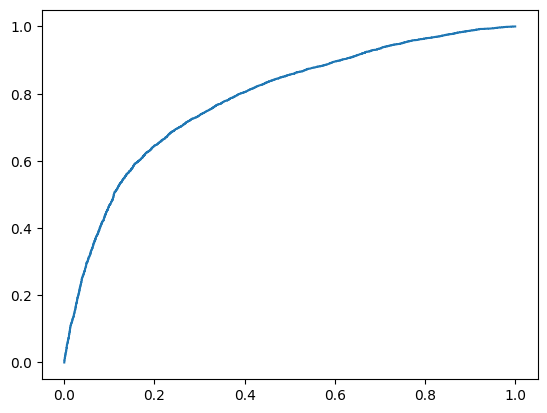

In [65]:
#plot the fpr and tpr
plt.plot(fpr,tpr)

In [66]:
#get the geometric mean
gmeans = np.sqrt(tpr*(1-fpr))

In [67]:
#print the treshold with the highest geometric means and the highest geometric means
print(tresholds[np.argmax(gmeans)])
print(gmeans[np.argmax(gmeans)])

0.4665900136854577
0.7231889388268558


In [68]:
#set a new treshold for the predictions as the treshold with the 
#geometric mean
new_pred = []
for x in log_pred_prob[:,1]:
    if x < 0.4562966244599074:
        new_pred.append(0)
    else:
        new_pred.append(1)

In [69]:
print('accuracy_score:', accuracy_score(new_pred,y_test))
print('f1_score', f1_score(new_pred,y_test))
print('precision_score:' , precision_score(new_pred,y_test))
print('recall_score:' , recall_score(new_pred,y_test))

accuracy_score: 0.7234826163818503
f1_score 0.7127333945515764
precision_score: 0.6953859937285352
recall_score: 0.7309684507926543


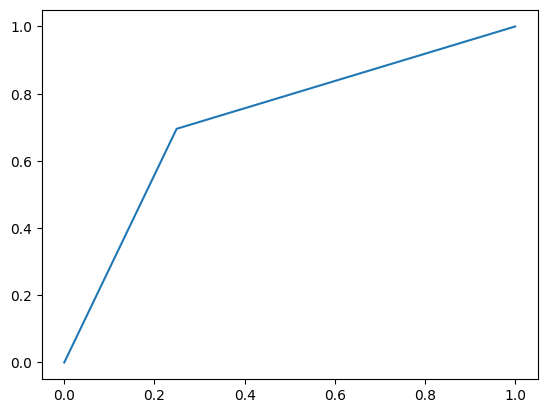

In [70]:
#plot the new fpr and tpr
fpr, tpr, tresholds = roc_curve(y_test,new_pred)
plt.plot(fpr,tpr)

from the above, we can see that our hypothesis seems to be in the right direction with an increase in our metrics . Lets further tune our model. by improving the treshold

In [71]:
#optimizing the random forest model 
#tune the hyperparameter for criterion to gini 
Rand_for = RandomForestClassifier(criterion='gini')
Rand_for.fit(x_train,y_train)

RandomForestClassifier()

In [72]:
Ran_for_pred = Rand_for.predict(x_test)

In [73]:
print('Random Forest accuracy_score:', accuracy_score(Ran_for_pred, y_test))
print('Random Forest  f1_score', f1_score(Ran_for_pred, y_test))
print(' Random Forest precision_score:' , precision_score(Ran_for_pred, y_test))
print('Random Forest  recall_score:' , recall_score(Ran_for_pred, y_test))

Random Forest accuracy_score: 0.6887153800824986
Random Forest  f1_score 0.6794113184645729
 Random Forest precision_score: 0.6686576078841272
Random Forest  recall_score: 0.6905165767154973


In [74]:
#get the prediction probabilities for random forest 
ran_pred_prob = Rand_for.predict_proba(x_test)

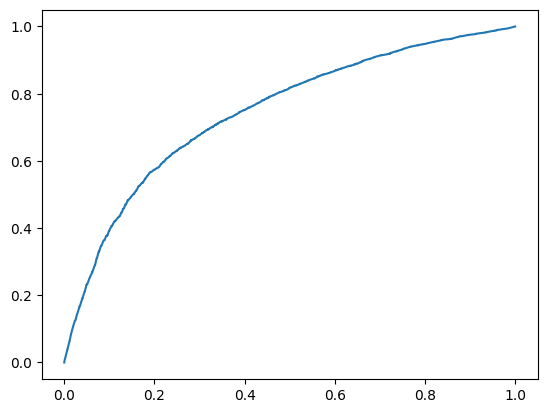

In [75]:
#get the false positive rate, true positive rate, tresholds and plot
fpr,tpr,tresholds = roc_curve(y_test,ran_pred_prob[:,1]) 
plt.plot(fpr,tpr)

In [76]:
#get the geometric mean
gmeans = np.sqrt(tpr*(1-fpr))
#print tresholds and gmeans
print(tresholds[np.argmax(gmeans)])
print(gmeans[np.argmax(gmeans)])


0.5133333333333333
0.6896992104436624


In [77]:
#set new probability treshold
ran_new_pred = []
for x in ran_pred_prob[:,1]:
    if x < 0.4562966244599074:
        ran_new_pred.append(0)
    else:
        ran_new_pred.append(1)

In [78]:
print('optimized random forest accuracy_score:', accuracy_score(ran_new_pred,y_test))
print('optimized random forest f1_score', f1_score(ran_new_pred,y_test))
print('optimized random forest precision_score:' , precision_score(ran_new_pred,y_test))
print('optimized random forest recall_score:' , recall_score(ran_new_pred,y_test))

optimized random forest accuracy_score: 0.6854743665291692
optimized random forest f1_score 0.6895448596771848
optimized random forest precision_score: 0.7080782439898462
optimized random forest recall_score: 0.6719569222049029


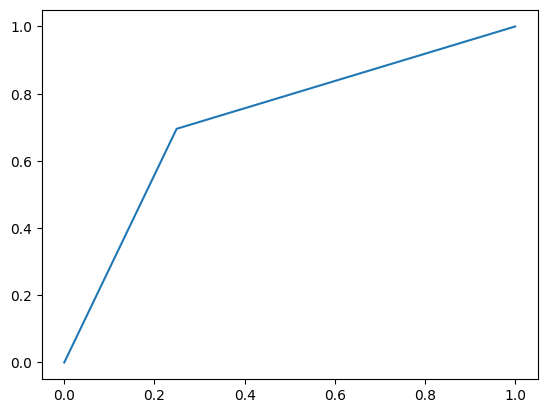

In [79]:
#optimised random forest  roc curve 
fpr, tpr, tresholds = roc_curve(y_test,new_pred)
plt.plot(fpr,tpr)

In [80]:
#build a knn classifier with split dataset
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [81]:
knn_pred = knn.predict(x_test)

In [82]:
print('knn accuracy_score:', accuracy_score(knn_pred,y_test))
print('knn f1_score', f1_score(knn_pred,y_test))
print('knn precision_score:' , precision_score(knn_pred,y_test))
print('knn recall_score:' , recall_score(knn_pred,y_test))

knn accuracy_score: 0.6808338243959929
knn f1_score 0.6669740988394436
knn precision_score: 0.647902045692101
knn recall_score: 0.6872030408615775


due to limited computational power, the optimization of the knn model was done without the random search and grid search cross validation. Although it was attemptedl

Below is the manual optimization of the knn model through hyperparameter tuning 

In [83]:
#optimized knn with new hyperparameters
optimized_knn = KNeighborsClassifier(n_neighbors=20, weights='distance',metric='manhattan')

In [84]:
optimized_knn.fit(x_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=20, weights='distance')

In [85]:
op_knn_pred = optimized_knn.predict(x_test)

In [86]:
print('optimized knn accuracy_score:', accuracy_score(op_knn_pred,y_test))
print('optimized knn f1_score', f1_score(op_knn_pred,y_test))
print('optimized knn precision_score:' , precision_score(op_knn_pred,y_test))
print('optimized knn recall_score:' , recall_score(op_knn_pred,y_test))

optimized knn accuracy_score: 0.698733058338244
optimized knn f1_score 0.6833384948900589
optimized knn precision_score: 0.658951769449007
optimized knn recall_score: 0.7095996140858659


attempted optimization of the knn model with cross validation (random search and grid search)

In [87]:
# optimizing the KNN model
# select parameters
#knn_para = {'n_neighbors': list(range(1,50)), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}

# Define the models
#knn = KNeighborsClassifier()

# Define GridSearchCV
#gridsearch_knn = GridSearchCV(knn, knn_para, cv=10, scoring='recall')
    #nb, params_nb, cv=5)
#randomsearch_knn = RandomizedSearchCV(knn, knn_para, cv=10, n_iter = 50, scoring='recall')

# Fit models
#gridsearch_knn.fit(x_train, y_train)
#randomsearch_knn.fit(x_train, y_train)

# Get the best parameters
#print("Best parameters for KNN - gridsearch: ", gridsearch_knn.best_params_)
#print("Best parameters for KNN - randomsearch: ", randomsearch_knn.best_params_)

# SVC Model

Because SVC model does not working good with large features, so we use logistic regression to reduced the feaures that we use for SVC model

In [88]:
log = LogisticRegression()
log.fit(data[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab']]
, data['cardio'])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [89]:
pred = log.predict(data[['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi',
       'high_glu', 'high_chol', 'high_bmi', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab']]
)

In [90]:
print(accuracy_score(pred,data['cardio']))
print(f1_score(pred,data['cardio']))
print(precision_score(pred,data['cardio']))
print(recall_score(pred,data['cardio']))

0.7265093255546716
0.701850186303482
0.6534872592415361
0.7579436658803941


In [91]:
log_coef=pd.DataFrame([log.feature_names_in_,log.coef_.flatten()]).T
log_coef.sort_values(by = 1,inplace = True)
log_coef

,0,1
14,chol_norm,-0.307701
5,bmi,-0.16382
15,chol_ab,-0.117607
6,high_glu,-0.112452
13,gluc_wab,-0.065993
1,height,-0.063342
12,gluc_ab,-0.046459
8,high_bmi,0.001307
4,ap_lo,0.00193
3,ap_hi,0.051907


According to the logistic regression coefficent, we could pick out the variables that siginificant to the model.

'chol_wab' : Chol well above average
'high_bp'
'high_chol' Those 3 variable is significant to the model.

'weight','low_bp','ap_hi','age' has meduim siginificant to the model include these varibales will increased the accuracy 

'ap_lo' and 'high_bmi' is relatively less significant to the model

'gluc_wab','height','high_glu','bmi','chol_norm'

Next Step I will try to delete the variables that not significant to the model to see if it bring significant change to the model
We want to use as less variables as we could but also keep high accuracy. In this case, our model like SVC could be less time consuming

In [92]:
#Delete 'ap_lo' and 'high_bmi'
variables = data[['age', 'height', 'weight', 'ap_hi',  'bmi',
       'high_glu', 'high_chol', 'high_bp', 'low_bp', 'gluc_norm',
       'gluc_ab', 'gluc_wab', 'chol_norm', 'chol_ab', 'chol_wab']]

log = LogisticRegression()
log.fit(variables, data['cardio'])

pred = log.predict(variables)

print(accuracy_score(pred,data['cardio']))
print(f1_score(pred,data['cardio']))
print(precision_score(pred,data['cardio']))
print(recall_score(pred,data['cardio']))

0.7259053006865258
0.6991672730212628
0.646608445986362
0.7610264352845929


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Variable Deletion Rationale:

1. 'height': they are all medium significant to the data. Form our previous oberservation, we noticed the individauls with higher weight will more likely to have cardiovascular but in the coefficent 'weight' is not significant to the model. In addition, a heavey weight of individaul could due to varios reason like they have more muscle mass or have heavier bone mass. In the dataset, we also have a variable called 'bmi' it is a caculation use weight and height to determine if someone is overweight. So we keep the bmi to represent the 'height' and 'weight'

2. 'gluc_ab' ,'gluec_ab': those two could be represent by ‘high_glu’ because it is combine by the gluc above average and well above average.

3. 'chol_ab', 'chol_wab' could represented by 'high_chol' 

4. 'low_bp' is not significant to the model after delete it the accuracy is increasing

This feature election is mainly for SVC model, since SVC might be the most time consuming model among the models we choose less variable would reduce the modeling time. 

In [93]:
#Delete 'height', 'gluc_ab', 'gluc_wab', 'chol_ab', 'chol_wab','weight','low_bp'
variables = data[['age', 'ap_hi',  'bmi','high_glu', 'high_chol', 'high_bp', 'gluc_norm', 'chol_norm']]

log = LogisticRegression()
log.fit(variables, data['cardio'])

pred = log.predict(variables)

print(accuracy_score(pred,data['cardio']))
print(f1_score(pred,data['cardio']))
print(precision_score(pred,data['cardio']))
print(recall_score(pred,data['cardio']))

0.7227083885795103
0.6971228115345005
0.6478346692188061
0.7545283544656541


In [94]:
from sklearn.svm import SVC

In [95]:
x = data[['age', 'ap_hi','bmi','high_glu', 'high_chol', 'high_bp', 'gluc_norm', 'chol_norm']]
y = data['cardio']

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1234)

In [100]:
svc = SVC(kernel='linear')
svc.fit(x_train, y_train)

SVC(kernel='linear')

In [101]:
pred_sv = svc.predict(x_test)
print(accuracy_score(pred_sv,y_test))
print(f1_score(pred_sv,y_test))
print(precision_score(pred_sv,y_test))
print(recall_score(pred_sv,y_test))

0.7181791396582203
0.6852065163732105
0.6217709422129312
0.7630566245189665


In [106]:
# Now let  find the best params for SVC
params_svc = {
     'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf','sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1]
   }
randomsearch_svc = RandomizedSearchCV(svc, params_svc,n_iter=1 )
randomsearch_svc.fit(x_train,y_train)
best_params = randomsearch_svc.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'kernel': 'linear', 'gamma': 1, 'C': 10}


Because the dataset is too big and I have limited computational power. So I set the n_iter =  2.
It will decrease the accuracy but increase the efficiency. 

In [107]:
svc = SVC(kernel='linear',gamma=1,C=10)
svc.fit(x_train, y_train)

SVC(C=10, gamma=1, kernel='linear')

In [108]:
pred_sv = svc.predict(x_test)
print(accuracy_score(pred_sv,y_test))
print(f1_score(pred_sv,y_test))
print(precision_score(pred_sv,y_test))
print(recall_score(pred_sv,y_test))

0.7184737772539777
0.6987704918032787
0.6619381812751979
0.7399432482056418


# Model evaluation

## Metrics Selection Rationale
Metrics Selection Rationale:

1.	Precision Score: This metric represents sure the true positive perdition out of all the positive predictions. It measures the accuracy of the positive prediction of the model. This is a crucial metric for this Cardiovascular dataset. Since the model is predicting if the person has Cardiovascular. A high Precision score model could have patients prevent unnecessary tests or treatment. It will also help hospitals save resources.

2.	Recall Score: This metric represents the true positive prediction out of the actual positive sample, which measures the ability of the model to correctly identify the positive model. In this case, this metric will be a significant metric. Cardiovascular refers to a group of conditions that affect the heart and blood vessels, including coronary artery disease, heart failure, arrhythmias, and stroke. It is one of the leading causes of death worldwide. The best way to mitigate the risk of Cardiovascular is through prevention and early detection. A high Recall Score means the model could effectively predict the actual positive case which helps the patient detect the disease. After it is diagnosed by the doctor, the patient can effectively prevent the risk of Cardiovascular. 

3.	Accuracy Score: This provides a general measure of how well the model is we could use it as a side metric. 

4.	F1_Score: This is the harmonic mean of precision and recall, it balanced the precision and recall, and it is a good metric to evaluate the model if the dataset is unbalanced. According to our EDA, the dataset is balanced our model might not have bias. However, In order to prevent the imbalanced positive and negative samples in the training dataset, we put this as a support metric to mitigate the risk. 

5.	Training and Prediction time: It will not be the main evaluation metric in this case. However, when it comes to the big datasets or real-time prediction it could be a practical consideration. 

SVC has the highest Recall score which means it has a better ability to correctly predict the positive model. This could help individuals predict if they have the potential to have cardiovascular, then distinguish the disease early. However, it is time-consuming to train and use the model to predict if the dataset is too large.

The Logistic regression model shows the highest evaluation score and most optimized time. It has the highest accuracy score, F1 score, second highest recall score, and relatively shorter training and predicting time. Thus, logistic regression is the best model among these models to predict if individuals have Cardiovascular or not.


# Conclusion

In our endeavour to predict the risk of cardiovascular disease from a substantial dataset of 70,000 patient records, we embarked on a meticulous journey that encompassed initial data cleaning, in-depth analysis, feature modifications, and model development. Our analysis reaffirmed our hypothesis, highlighting age, blood pressure, cholesterol levels, and BMI as pivotal indicators in predicting the likelihood of cardiovascular diseases.

Addressing our problem statement, we employed four machine learning models: Logistic Regression, Random Forest, K-Nearest Neighbours, and Support Vector Machines. After testing, the Logistic Regression model stood out as the optimal choice. It effectively balanced accuracy with speed, and its impressive recall rate ensures that individuals at potential risk are promptly identified, facilitating early and potentially lifesaving interventions.

To sum up, the early identification and treatment of cardiovascular diseases are crucial. Our study showcases how machine learning can be a powerful tool in the healthcare sector, aiding professionals in identifying risks and making decisions based on data-driven insights. We believe that the methods and findings from this research will not only benefit medical practitioners but will also inspire more such studies, emphasizing the importance of technology in modern healthcare.
